In [1]:
from quasinet.qnet import load_qnet
from quasinet.qnet import qdistance
from quasinet.qsampling import qsample
from quasinet.qnet import membership_degree
import pandas as pd
import numpy as np
from tqdm import tqdm
from jupyterthemes import jtplot
jtplot.style()



In [3]:
def dissonance(pos,seq,model):
    if seq[pos]=='':
        return np.nan
    D=model.predict_distributions(seq) 
    return 1-D[pos].get(str(seq[pos]),0)
def dissonance_distr(seq,model):
    return np.array([dissonance(pos,seq,model) for pos in range(len(seq))])

def dissonance_distr_median(seq,model):
    a=dissonance_distr(seq,model)
    return np.median(a[~np.isnan(a)])

# create a naive posstr
def sample_from_pmf(pmf, L):
    """
    Draw L samples from the given PMF.

    :param pmf: A dictionary representing the PMF where keys are outcomes and values are probabilities.
    :param L: The number of samples to draw.
    :return: A list of L samples.
    """
    # Extract the outcomes and their corresponding probabilities
    outcomes = list(pmf.keys())
    probabilities = list(pmf.values())

    # Draw L samples from the outcomes based on the specified probabilities
    samples = np.random.choice(outcomes, size=L, p=probabilities)
    return samples   


In [4]:
pathdata='/home/ishanu/ZED/Research/truthnet/notebooks/data/ptsd/PTSD_cognet_test.csv'
df=pd.read_csv(pathdata,index_col=0)
model_neg=load_qnet('ptsd_neg.pkl.gz',gz=True)
model_pos=load_qnet('ptsd_pos.pkl.gz',gz=True)
INDEX=model_neg.shap_index
featurenames=df.drop('PTSDDx',axis=1).columns

In [98]:
NULLSTR=np.array(['']*len(model_neg.feature_names))
s1=qsample(NULLSTR,model_pos,steps=100000)
s0=qsample(NULLSTR,model_neg,steps=100000)

def func(s,s0,s1,model_pos,model_neg):
    return qdistance(s0,s,model_neg,model_neg)/qdistance(s1,s,model_pos,model_pos)

def funcw(s,model_pos,model_neg):
    return membership_degree(s,model_neg)/membership_degree(s,model_pos)

def funcm(array):
    if isinstance(array, np.ndarray):
        if isinstance(array[0], str):
            return -membership_degree(array,model_pos)/(array!='').sum() 
        if isinstance(array[0],np.ndarray):
            if isinstance(array[0][0], str):
                return np.array([-membership_degree(s,model_pos)/(s!='').sum()  for s in array])
    raise('incorrect datatype. must be 2d numpy array of strings')
    return
                
def calcVeritas(s):
    c0,c1=funcm(s),dissonance_distr_median(s,model_pos)#,funcw(POSSTR)
    return (c0>1,c1<0.76)
        
    
    

In [99]:
dist={'3':0.3,'4':.2,'5':.5}
#dist={'1':.6,'2':.25,'3':.1,'4':.05,'5':0}
POSSTR=sample_from_pmf(dist,211)
print(membership_degree(POSSTR,model_pos),dissonance_distr_median(POSSTR,model_pos),funcw(POSSTR))
calcVeritas(POSSTR)
# mem > -250, funcw > 1, but diss > .75 ===> malingering

(True, False)

In [119]:
dist={'1':.3,'2':.1,'3':0.2,'4':.3,'5':.1}
#dist={'1':.6,'2':.25,'3':.1,'4':.05,'5':0}
POSSTR=sample_from_pmf(dist,211)
print(funcm(POSSTR),dissonance_distr_median(POSSTR,model_pos),funcw(POSSTR,model_pos,model_neg))
calcVeritas(POSSTR)

# mem > -250, funcw > 1, but diss > .75 ===> malingering

1.4969629242516442 0.834319526627219 1.1427220748856868


(True, False)

In [121]:
sq=qsample(NULLSTR,model_pos,steps=1000)
print(sq,funcm(sq),dissonance_distr_median(sq,model_pos),funcw(sq,model_pos,model_neg))
calcVeritas(sq)

# note for a legitimate rerposnse, funcw > 1, diss < 0.7, mem > -250

['5' '3' '2' '4' '2' '2' '3' '5' '2' '2' '1' '4' '5' '4' '4' '3' '4' '3'
 '4' '4' '1' '1' '3' '3' '4' '3' '3' '4' '3' '5' '2' '3' '5' '4' '3' '3'
 '3' '3' '3' '4' '4' '4' '3' '4' '2' '1' '3' '3' '4' '4' '2' '3' '3' '1'
 '3' '1' '5' '1' '3' '3' '4' '1' '1' '1' '4' '3' '4' '4' '2' '5' '' '2'
 '2' '2' '2' '4' '4' '4' '2' '3' '3' '3' '2' '' '4' '1' '3' '3' '5' '4'
 '4' '4' '3' '3' '3' '4' '5' '2' '4' '5' '3' '3' '1' '3' '2' '4' '4' '4'
 '4' '5' '4' '2' '2' '2' '1' '1' '4' '1' '4' '3' '3' '3' '4' '4' '4' '4'
 '2' '4' '1' '4' '5' '2' '4' '' '4' '3' '5' '4' '4' '3' '4' '3' '3' '3'
 '4' '3' '5' '4' '2' '5' '3' '2' '2' '4' '3' '2' '2' '4' '4' '5' '1' '1'
 '4' '3' '4' '4' '3' '1' '3' '3' '3' '1' '3' '4' '2' '2' '4' '2' '3' '4'
 '2' '2' '1' '4' '4' '4' '3' '1' '1' '1' '2' '5' '3' '5' '3' '3' '3' '4'
 '3' '5' '3' '3' '2' '1' '3' '3' '1' '2' '3' '5' '4'] 1.1523796407364442 0.6723704013377927 1.6632964686019538


(True, True)

In [160]:
sq=qsample(NULLSTR,model_pos,steps=1000)
a=pd.DataFrame(sq).T
a.columns=featurenames
s=pd.concat([pd.DataFrame(columns=featurenames),a[INDEX[:20]]]).fillna('')
sq=s.values[0].astype(str)
#print(sq,funcm(sq),dissonance_distr_median(sq,model_pos),funcw(sq,model_pos,model_neg))
#calcVeritas(sq)
adict=a[INDEX[:20]].T.to_dict()


{0: {'ptsd102': '5',
  'ptsd90': '4',
  'ptsd170': '2',
  'ptsd31': '4',
  'ptsd71': '5',
  'ptsd179': '2',
  'ptsd172': '1',
  'ptsd142': '3',
  'ptsd165': '3',
  'ptsd210': '5',
  'ptsd171': '3',
  'ptsd74': '3',
  'ptsd135': '3',
  'ptsd166': '4',
  'ptsd40': '4',
  'ptsd16': '4',
  'ptsd98': '3',
  'ptsd139': '2',
  'ptsd145': '4',
  'ptsd50': '3'}}

In [129]:
featurenames

Index(['ptsd1', 'ptsd2', 'ptsd3', 'ptsd4', 'ptsd5', 'ptsd6', 'ptsd7', 'ptsd8',
       'ptsd9', 'ptsd10',
       ...
       'ptsd202', 'ptsd203', 'ptsd204', 'ptsd205', 'ptsd206', 'ptsd207',
       'ptsd208', 'ptsd209', 'ptsd210', 'ptsd211'],
      dtype='object', length=211)

In [121]:
print(sq,funcm(sq),dissonance_distr_median(sq,model_pos),funcw(sq,model_pos,model_neg))
calcVeritas(sq)

# note for a legitimate rerposnse, funcw > 1, diss < 0.7, mem > -250

['5' '3' '2' '4' '2' '2' '3' '5' '2' '2' '1' '4' '5' '4' '4' '3' '4' '3'
 '4' '4' '1' '1' '3' '3' '4' '3' '3' '4' '3' '5' '2' '3' '5' '4' '3' '3'
 '3' '3' '3' '4' '4' '4' '3' '4' '2' '1' '3' '3' '4' '4' '2' '3' '3' '1'
 '3' '1' '5' '1' '3' '3' '4' '1' '1' '1' '4' '3' '4' '4' '2' '5' '' '2'
 '2' '2' '2' '4' '4' '4' '2' '3' '3' '3' '2' '' '4' '1' '3' '3' '5' '4'
 '4' '4' '3' '3' '3' '4' '5' '2' '4' '5' '3' '3' '1' '3' '2' '4' '4' '4'
 '4' '5' '4' '2' '2' '2' '1' '1' '4' '1' '4' '3' '3' '3' '4' '4' '4' '4'
 '2' '4' '1' '4' '5' '2' '4' '' '4' '3' '5' '4' '4' '3' '4' '3' '3' '3'
 '4' '3' '5' '4' '2' '5' '3' '2' '2' '4' '3' '2' '2' '4' '4' '5' '1' '1'
 '4' '3' '4' '4' '3' '1' '3' '3' '3' '1' '3' '4' '2' '2' '4' '2' '3' '4'
 '2' '2' '1' '4' '4' '4' '3' '1' '1' '1' '2' '5' '3' '5' '3' '3' '3' '4'
 '3' '5' '3' '3' '2' '1' '3' '3' '1' '2' '3' '5' '4'] 1.1523796407364442 0.6723704013377927 1.6632964686019538


(True, True)

In [ ]:
# stratgey:
# membership degree must be greater than -250
# dissonance median must be less than .735 (actually less than equal to .76)

In [17]:
import json
filepath='/home/ishanu/Dropbox/paraknowledge/paraknowledgecorp/webpage/veritas/responses2.json'
with open(filepath, 'r') as file:
    data = json.load(file)
#data

In [18]:
sr=pd.concat([pd.DataFrame(columns=model_pos.feature_names),
           pd.DataFrame(data['questionnaireResponses'][0]['dweede'],index=['resp'])]).fillna('').values[0].astype(str)

In [74]:
sr,membership_degree(sr,model_pos)/(sr!='').sum(),dissonance_distr_median(sr,model_pos),funcw(sr)
# note for incomplete response, we cannot depend on mem as the emty string swill boostup mm
# but clearly diss is too high indicating malingering
# but note that funcw > 1, which indicates POS classification

(array(['', '', '5', '3', '', '5', '3', '', '', '3', '5', '4', '', '', '',
        '3', '', '', '', '', '4', '4', '4', '', '5', '', '', '', '4', '',
        '', '', '', '', '', '', '', '', '5', '', '', '5', '', '', '', '',
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', '', '', '', '', '', '', '', '', '', '5', '5', '3', '', '', '',
        '', '', '', '', '5', '5', '4', '4', '', '', '', '', '5', '', '',
        '', '5', '5', '4', '', '', '', '', '4', '', '', '3', '4', '', '',
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '5', '', '5', '', '4', '3', '5', '4', '2', '4', '4', '5', '', '5',
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', '', ''], dty

In [20]:
# the diss threshold needs to be characterized better
# maybe by restricting questions to inifitail entries in teh SHAP ordered INDEX vector of the featurenames

In [50]:
df_test_pos=df.loc[[x for x in df.index.values if x not in model_pos.training_index],:]
df_test_pos=df_test_pos[df_test_pos.PTSDDx==1].drop('PTSDDx',axis=1)
Xpos_test=df_test_pos.values
Xpos_test_incomplete=pd.concat([pd.DataFrame(columns=featurenames),df_test_pos[INDEX[:20]]]).fillna('').values.astype(str)

In [51]:
mx=np.array([membership_degree(x.astype(str),model_pos) for x in Xpos_test.values])

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [124]:
Xpos_test[10]

array([5, 2, 5, 3, 3, 5, 3, 5, 4, 3, 4, 3, 4, 3, 5, 5, 4, 5, 5, 3, 3, 5,
       5, 4, 4, 4, 4, 3, 5, 5, 4, 5, 5, 5, 5, 4, 4, 3, 4, 4, 5, 3, 2, 4,
       1, 2, 1, 4, 4, 3, 1, 3, 3, 2, 4, 3, 5, 5, 5, 5, 5, 1, 1, 4, 4, 4,
       4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 3, 5, 5, 5,
       5, 4, 4, 4, 4, 4, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 5,
       5, 4, 1, 5, 1, 1, 1, 3, 4, 4, 4, 2, 4, 4, 4, 1, 4, 4, 4, 5, 5, 4,
       4, 3, 4, 3, 4, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 3, 3, 1, 5, 4, 4, 4, 3, 4, 4, 4, 4, 5, 5, 4, 4, 4,
       4, 3, 3, 3, 4, 3, 5, 4, 3, 3, 4, 2, 3, 2, 4, 4, 4, 4, 4, 4, 5, 5,
       4, 3, 3, 3, 4, 4, 3, 5, 4, 5, 5, 5, 5])

In [161]:
sq=Xpos_test[10].astype(str)

print(sq,funcm(sq),dissonance_distr_median(sq,model_pos),funcw(sq,model_pos,model_neg))
calcVeritas(sq)

['5' '2' '5' '3' '3' '5' '3' '5' '4' '3' '4' '3' '4' '3' '5' '5' '4' '5'
 '5' '3' '3' '5' '5' '4' '4' '4' '4' '3' '5' '5' '4' '5' '5' '5' '5' '4'
 '4' '3' '4' '4' '5' '3' '2' '4' '1' '2' '1' '4' '4' '3' '1' '3' '3' '2'
 '4' '3' '5' '5' '5' '5' '5' '1' '1' '4' '4' '4' '4' '5' '5' '5' '5' '5'
 '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '2' '3' '5' '5' '5' '5' '4'
 '4' '4' '4' '4' '4' '5' '5' '5' '4' '5' '5' '5' '5' '5' '4' '4' '4' '4'
 '4' '5' '5' '4' '1' '5' '1' '1' '1' '3' '4' '4' '4' '2' '4' '4' '4' '1'
 '4' '4' '4' '5' '5' '4' '4' '3' '4' '3' '4' '3' '3' '3' '3' '4' '4' '4'
 '4' '5' '5' '5' '5' '5' '3' '3' '4' '4' '4' '4' '4' '4' '4' '3' '3' '1'
 '5' '4' '4' '4' '3' '4' '4' '4' '4' '5' '5' '4' '4' '4' '4' '3' '3' '3'
 '4' '3' '5' '4' '3' '3' '4' '2' '3' '2' '4' '4' '4' '4' '4' '4' '5' '5'
 '4' '3' '3' '3' '4' '4' '3' '5' '4' '5' '5' '5' '5'] 1.10061687171405 0.6609442060085837 2.102095579245925


(True, True)

In [162]:
sq

array(['5', '2', '5', '3', '3', '5', '3', '5', '4', '3', '4', '3', '4',
       '3', '5', '5', '4', '5', '5', '3', '3', '5', '5', '4', '4', '4',
       '4', '3', '5', '5', '4', '5', '5', '5', '5', '4', '4', '3', '4',
       '4', '5', '3', '2', '4', '1', '2', '1', '4', '4', '3', '1', '3',
       '3', '2', '4', '3', '5', '5', '5', '5', '5', '1', '1', '4', '4',
       '4', '4', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5',
       '5', '5', '5', '5', '5', '2', '3', '5', '5', '5', '5', '4', '4',
       '4', '4', '4', '4', '5', '5', '5', '4', '5', '5', '5', '5', '5',
       '4', '4', '4', '4', '4', '5', '5', '4', '1', '5', '1', '1', '1',
       '3', '4', '4', '4', '2', '4', '4', '4', '1', '4', '4', '4', '5',
       '5', '4', '4', '3', '4', '3', '4', '3', '3', '3', '3', '4', '4',
       '4', '4', '5', '5', '5', '5', '5', '3', '3', '4', '4', '4', '4',
       '4', '4', '4', '3', '3', '1', '5', '4', '4', '4', '3', '4', '4',
       '4', '4', '5', '5', '4', '4', '4', '4', '3', '3', '3', '4

In [ ]:
dpos=np.array([dissonance_distr_median(x,model_pos) for x in tqdm(Xpos_test)])

In [52]:
dpos_inc=np.array([dissonance_distr_median(x,model_pos) for x in tqdm(Xpos_test_incomplete)])

100%|███████████████████████████████████████████| 56/56 [00:24<00:00,  2.25it/s]


In [53]:
dpos.sort()
dpos_inc.sort()

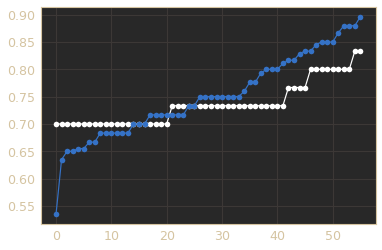

In [44]:
import pylab as plt
plt.plot((np.array(dpos)),'-wo')
plt.plot((np.array(dpos_inc)),'-o')

In [65]:
len(dpos[dpos>.76])

14

In [49]:
len(dpos_inc[dpos_inc>.8])

15

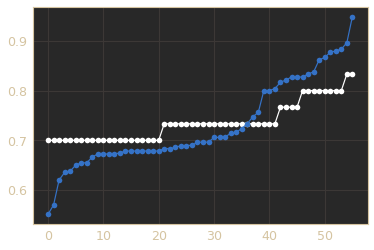

In [54]:
plt.plot((np.array(dpos)),'-wo')
plt.plot((np.array(dpos_inc)),'-o')

In [188]:
len(dpos_inc[dpos_inc>.75])

18

In [ ]:
plt.hist(dpos,alpha=.3)
plt.hist(dposfull,alpha=.3)

In [79]:
!pwd

/home/ishanu/ZED/Research/truthnet/notebooks/deployment-assets/models/ptsd


In [107]:
A=[calcVeritas(x) for x in tqdm(Xpos_test_incomplete)]

100%|███████████████████████████████████████████| 56/56 [00:28<00:00,  1.96it/s]


In [111]:
Af=pd.DataFrame(A,columns=['mem','mal'])

In [114]:
Af[~Af.mal]

,mem,mal
6,True,False
7,True,False
12,True,False
15,True,False
17,True,False
19,True,False
22,True,False
24,True,False
31,True,False
33,True,False


In [115]:
Af[~Af.mem]

,mem,mal
0,False,True
3,False,True
4,False,True
8,False,True
14,False,True
18,False,True
20,False,True
21,False,True
25,False,True
26,False,True


In [116]:
Am=[funcw(x,model_pos,model_neg) for x in tqdm(Xpos_test_incomplete)]

100%|███████████████████████████████████████████| 56/56 [00:03<00:00, 17.01it/s]


In [117]:
Am

[1.6738080543319331,
 1.2639427650396131,
 1.7328446661744072,
 1.532897969934514,
 2.3345800286046225,
 1.6252167351781979,
 0.7957592205529147,
 0.6181862520059739,
 1.8529108086109223,
 1.7010000266083705,
 1.8818547857010968,
 1.4470913937557859,
 0.8871341214847263,
 1.4175453953119446,
 2.304382211459258,
 0.921689784575087,
 1.7679125986086413,
 1.15385131875142,
 1.6587539942428402,
 1.2364857573886814,
 1.5243672451763264,
 1.4180825550863334,
 1.259175123347387,
 1.2501203996405894,
 1.2320023673582252,
 1.730584047839319,
 2.1150273621890574,
 1.6667433744872135,
 1.1115028134327656,
 1.9527013073188253,
 1.8135109051935372,
 0.6513517325669901,
 1.2275791236008398,
 0.7290102636585651,
 1.8973851462036027,
 1.5242965839751503,
 1.5604415411065882,
 0.7167193495947356,
 0.817722238314598,
 1.2194482581093586,
 1.4130490307072532,
 1.6938828942762953,
 0.7478093909333859,
 1.6126008058928778,
 1.9349158268469926,
 1.4253529670314364,
 1.9353205498084975,
 0.7738805463187541,


In [285]:
INDEX=model_pos.shap_index
featurenames=model_pos.feature_names
XM={i:'3' for i in INDEX[:20]}

xm=pd.concat([pd.DataFrame(columns=featurenames),pd.DataFrame(XM,index=['resp'])]).fillna('').values[0].astype(str)

#xm=qsample(xm,model_pos,steps=10)

print(xm,funcm(xm),dissonance_distr_median(xm,model_pos),funcw(xm,model_pos,model_neg))
calcVeritas(xm)

['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '3' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '3' '' '' '' '' '' '' '' '' '3' '' '' '' '' '' '' '' ''
 '' '3' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '3' ''
 '' '3' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '3' '' '' '' '' '' ''
 '' '3' '' '' '' '3' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '3' '' '' '' '3' '' '' '3' ''
 '' '3' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '3' '3'
 '' '' '' '3' '3' '3' '' '' '' '' '' '' '3' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '3' ''] 0.9779630917707024 0.6353637901861252 1.4180825550863334


(False, True)

In [286]:
xm=qsample(xm,model_neg,steps=4)

print(xm,funcm(xm),dissonance_distr_median(xm,model_pos),funcw(xm,model_pos,model_neg))
calcVeritas(xm)

['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '3' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '3' '' '' '' '' '' '' '' '' '3' '' '' '' '' '' '' '' ''
 '' '3' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '3' ''
 '' '3' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '3' '' '' '' '' '' ''
 '' '3' '' '' '' '3' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '3' '' '' '' '' '' '' '' '3' '' '' '' '3' '' '' '3' ''
 '3' '3' '' '' '' '' '' '1' '' '' '' '' '' '' '' '' '' '' '' '' '' '3' '3'
 '' '' '' '3' '3' '3' '' '' '' '' '' '' '3' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '2' '' '' '' '' '' '' '' '' '3' ''] 0.9960110851315566 0.6353637901861252 1.3518550963216525


(False, True)

In [278]:
INDEX=model_pos.shap_index
featurenames=model_pos.feature_names
XM={i:'3' for i in INDEX[:20]}
xm=pd.concat([pd.DataFrame(columns=featurenames),pd.DataFrame(XM,index=['resp'])]).fillna('').values[0].astype(str)
A=[]
B=[]
for i in tqdm(range(100)):
    xm1=qsample(xm,model_neg,steps=10)
    a,b=dissonance_distr_median(xm1,model_pos),funcw(xm1,model_pos,model_neg)
    A=np.append(A,a)
    B=np.append(B,b)


100%|█████████████████████████████████████████| 100/100 [01:09<00:00,  1.43it/s]


<AxesSubplot:ylabel='Density'>

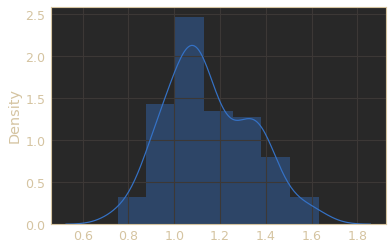

In [279]:
import seaborn as sns
sns.distplot(B)

In [280]:
B.sort()
B

array([0.75252648, 0.76668287, 0.84332839, 0.87098942, 0.88220322,
       0.88272096, 0.8931212 , 0.91355608, 0.91832775, 0.92198492,
       0.93218923, 0.9332891 , 0.93437569, 0.93513988, 0.94780356,
       0.95094675, 0.96172672, 0.96828429, 0.9704735 , 0.99712261,
       0.99918125, 1.0030802 , 1.00477141, 1.00987539, 1.01556082,
       1.02802213, 1.03297884, 1.03371481, 1.03636181, 1.0516113 ,
       1.05322755, 1.05794863, 1.06166106, 1.06307283, 1.06797753,
       1.07089838, 1.07290186, 1.07585937, 1.07749869, 1.07810769,
       1.07818239, 1.08276733, 1.08362727, 1.08462903, 1.09753704,
       1.09847071, 1.09895137, 1.10043955, 1.10173082, 1.11558467,
       1.11563066, 1.11914822, 1.12217347, 1.13299954, 1.13311776,
       1.1388255 , 1.13967889, 1.14811062, 1.15201029, 1.15918856,
       1.16825465, 1.17602429, 1.19197469, 1.19551099, 1.20294396,
       1.20346083, 1.20969859, 1.23956237, 1.24237744, 1.24434659,
       1.26145206, 1.27091671, 1.30005577, 1.31140477, 1.31625

In [255]:
XX={"ptsd48": "4", "ptsd78": "5", "ptsd145": "4", "ptsd166": "5", "ptsd71": "3", "ptsd72": "4", "ptsd138": "5", "ptsd170": "3", "ptsd93": "2", "ptsd139": "4", "ptsd29": "3", "ptsd102": "4", "ptsd172": "3", "ptsd159": "4", "ptsd142": "3", "ptsd40": "3", "ptsd165": "3", "ptsd135": "4", "ptsd171": "3", "ptsd16": "4"}

xm=pd.concat([pd.DataFrame(columns=featurenames),pd.DataFrame(XX,index=['resp'])]).fillna('').values[0].astype(str)


print(xm,funcm(xm),dissonance_distr_median(xm,model_pos),funcw(xm,model_pos,model_neg))
calcVeritas(xm)

['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '4' '' '' '' '' '' '' '' ''
 '' '' '' '' '3' '' '' '' '' '' '' '' '' '' '' '3' '' '' '' '' '' '' ''
 '4' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '3'
 '4' '' '' '' '' '' '5' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '2' ''
 '' '' '' '' '' '' '' '4' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '4' '' '' '5' '4' '' ''
 '3' '' '' '4' '' '' '' '' '' '' '' '' '' '' '' '' '' '4' '' '' '' '' ''
 '3' '5' '' '' '' '3' '3' '3' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''] 0.8219936720465831 0.7166666666666667 1.7795270296950128


(False, True)

In [256]:
xm=qsample(xm,model_neg,steps=10)

print(xm,funcm(xm),dissonance_distr_median(xm,model_pos),funcw(xm,model_pos,model_neg))
calcVeritas(xm)

['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '4' '' '' '' '' '' '' '' '3'
 '' '' '' '' '3' '' '' '' '' '' '' '' '' '' '' '3' '1' '' '' '' '' '' ''
 '4' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '3'
 '4' '' '' '4' '' '1' '5' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '2' ''
 '' '' '' '' '' '' '' '4' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '3'
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '4' '' '' '5' '4' '' ''
 '3' '' '2' '4' '' '' '' '' '' '' '' '2' '' '' '' '' '' '4' '4' '' '' ''
 '' '3' '5' '' '' '' '3' '3' '3' '2' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '1' '' '' '' '' '' '' '' '' '' '' ''
 '' ''] 1.0919727923865759 0.7782377919320594 1.1874806717498445


(True, False)